In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 35 kB/s 
     |████████████████████████████████| 198 kB 50.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=029b1535333434322c063611ded4115edfb7be1bbaf712fb75933275929bff7d
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


In [ ]:
#Read csv file to dataframe
#=====your code here==========
from pyspark import SparkContext 
from pyspark.sql import SQLContext
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

spark = SparkSession \
    .builder \
    .appName("Classification") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
data = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('/content/drive/My Drive/Data/APPL-data.csv')
#===============================
data.show(3)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+----------+----------+-----------+------------------+-----+------------------+
|     date0|     date1|close_value|              mean|count|        normalized|
+----------+----------+-----------+------------------+-----+------------------+
|2015-01-01|2015-01-01|     110.38|0.7692307692307693|  299|0.7666623884180624|
|2015-01-02|2015-01-02|     109.33|0.7905138339920948|  506|0.7889530964265398|
|2015-01-03|2015-01-03|     109.33|0.6362252663622526|  657|0.6352576235582568|
+----------+----------+-----------+------------------+-----+------------------+
only showing top 3 rows



In [ ]:
data = data.drop('date0').withColumnRenamed('date1','date')
data.printSchema()
data.show(2)


root
 |-- date: string (nullable = true)
 |-- close_value: double (nullable = true)
 |-- mean: double (nullable = true)
 |-- count: integer (nullable = true)
 |-- normalized: double (nullable = true)

+----------+-----------+------------------+-----+------------------+
|      date|close_value|              mean|count|        normalized|
+----------+-----------+------------------+-----+------------------+
|2015-01-01|     110.38|0.7692307692307693|  299|0.7666623884180624|
|2015-01-02|     109.33|0.7905138339920948|  506|0.7889530964265398|
+----------+-----------+------------------+-----+------------------+
only showing top 2 rows



In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.regression import GBTRegressor
from pyspark.sql.functions import log 

In [ ]:
data.show(5)

+----------+-----------+------------------+-----+------------------+
|      date|close_value|              mean|count|        normalized|
+----------+-----------+------------------+-----+------------------+
|2015-01-01|     110.38|0.7692307692307693|  299|0.7666623884180624|
|2015-01-02|     109.33|0.7905138339920948|  506|0.7889530964265398|
|2015-01-03|     109.33|0.6362252663622526|  657|0.6352576235582568|
|2015-01-04|     109.33| 0.666965085049239| 1117|0.6663682483239393|
|2015-01-05|     106.25|0.6966887417218544| 1510|0.6962275111913891|
+----------+-----------+------------------+-----+------------------+
only showing top 5 rows



Root Mean Squared Error (RMSE) on test data = 4.96987


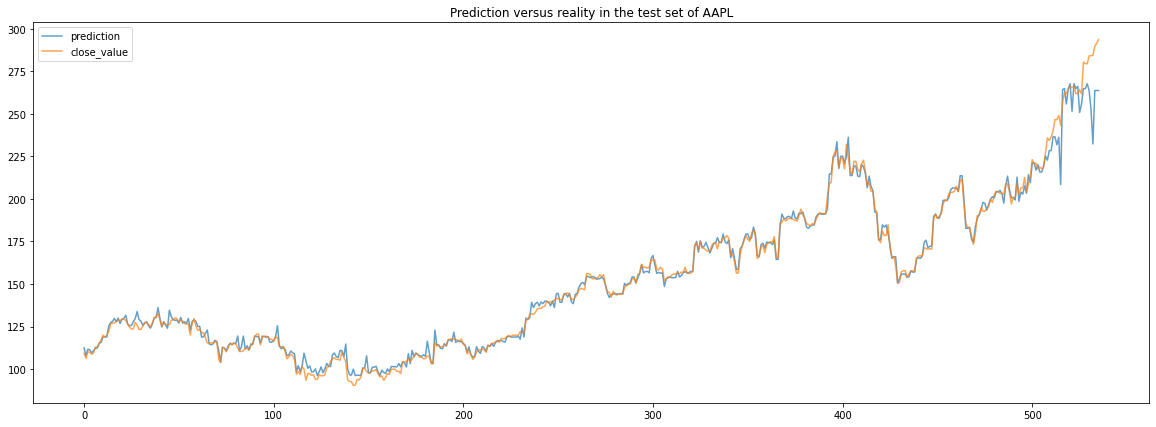

In [ ]:
AAPL = data.select("date","close_value","mean","count")
def RF(data):
  trainingData, testData = AAPL.randomSplit([0.7, 0.3])
  va = VectorAssembler().setInputCols(trainingData.columns[1:3]).setOutputCol('features')
  rf = RandomForestRegressor(labelCol="close_value", featuresCol="features",maxDepth=9,numTrees=200)
  pipe = Pipeline(stages=[va, rf])
  evaluator_rf = RegressionEvaluator(labelCol="close_value", predictionCol="prediction", metricName='rmse')
  model_rf = pipe.fit(trainingData)

  # Make predictions.
  predictions = model_rf.transform(testData)

  #RMSE 
  rmse = evaluator_rf.evaluate(predictions)
  print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
  # print("Feature importance as of column index:",model_rf.stages[-1].featureImportances)
  ##
  return predictions,testData,rmse
predictions,testData,rmse = RF(AAPL)

#Line plot comparing Prediction versus reality in the test set of AAPL
pred = predictions.toPandas()
test = testData.toPandas()
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(pred)), pred.prediction, alpha=0.7, label='prediction')
plt.plot(np.arange(len(test)), test.close_value, alpha=0.7, label='close_value' );
plt.title('Prediction versus reality in the test set of AAPL')
plt.legend();

Root Mean Squared Error (RMSE) on test data = 2.9492


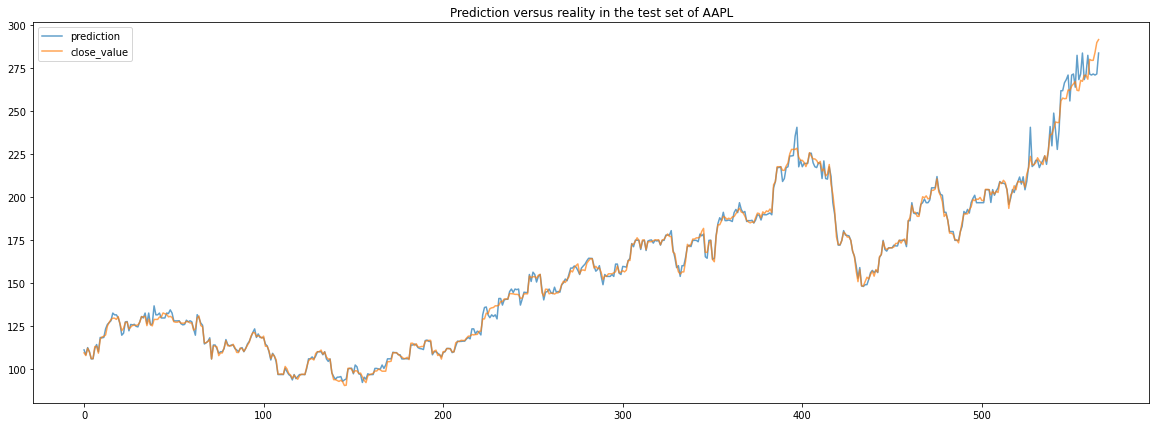

In [ ]:
from pyspark.ml.regression import GBTRegressor

def GBT(data):
  trainingData, testData = AAPL.randomSplit([0.7, 0.3])
  va = VectorAssembler().setInputCols(trainingData.columns[1:3]).setOutputCol('features')
  gbt = GBTRegressor(featuresCol="features",labelCol="close_value", maxIter=30,stepSize=0.0001,maxDepth=10)

  pipe = Pipeline(stages=[va, gbt])
  evaluator_gbt = RegressionEvaluator(labelCol="close_value", predictionCol="prediction", metricName='rmse')
  model_gbt = pipe.fit(trainingData)
  pred_gbt = model_gbt.transform(testData)

  rmse1_gbt = evaluator_gbt.evaluate(pred_gbt)

  print("Root Mean Squared Error (RMSE) on test data = %g" % rmse1_gbt)
  return pred_gbt,testData,rmse1_gbt

pred_gbt,testData,rmse1_gbt = GBT(AAPL)

#Line plot comparing Prediction versus reality in the test set of msft
pred = pred_gbt.toPandas()
test = testData.toPandas()
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(pred)), pred.prediction, alpha=0.7, label='prediction')
plt.plot(np.arange(len(test)), test.close_value, alpha=0.7, label='close_value' );
plt.title('Prediction versus reality in the test set of AAPL')
plt.legend();